In [53]:
"""
Train a 3d Unet with 128x128x128x3 3D images input and 1D Mask labels output.

data are .npy files in this practice
"""
import os
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random

### Define some functions to help reading prepared data.

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size



No. of images:  310


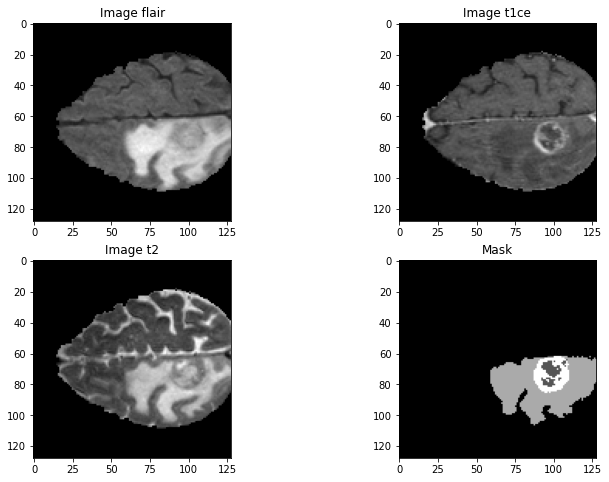

In [39]:
"""
Test reading data.
"""

train_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\mask\\"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

print("No. of images: ", num_images)

img_num = random.randint(0,num_images-1) # randomly load a data
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2]-1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.show()


In [42]:
# Define the image generators for training and testing (I use calidation data as the testing data)

train_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\mask\\"

val_img_dir = "I:\\Data\\Brain MRI\\\BraTS2020_Validation2Data\\input_data_3channels\\images\\"
val_mask_dir = "I:\\Data\\Brain MRI\\\BraTS2020_Validation2Data\\input_data_3channels\\mask\\"

test_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\input_data_3channels\\images\\"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

test_img_list=os.listdir(test_img_dir)


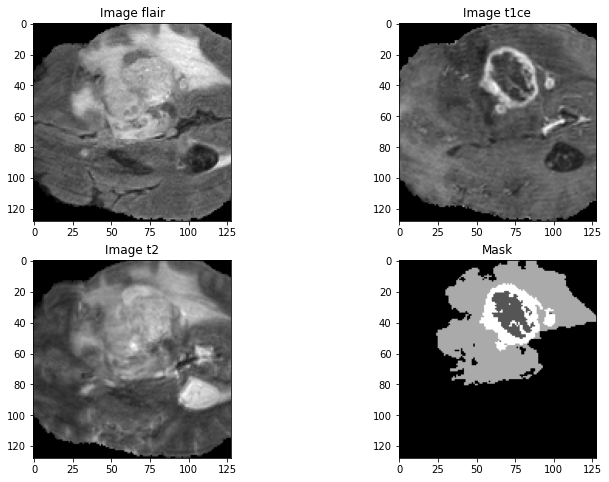

In [45]:
## Check loaded data
batch_size = 5

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()



img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2]-1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.show()


In [46]:
# Pick the model 
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_50 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_9[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_24 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_50[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_51 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_24[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [49]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

model.compile(optimizer = keras.optimizers.Adam(0.0001),
              loss = bce_jaccard_loss,
              metrics=[iou_score, 'accuracy'])
# print(model.summary())

print(model.input_shape)
print(model.output_shape)


(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [50]:
# Train the model

import tensorflow as tf

checkpointer = tf.keras.callbacks.ModelCheckpoint('brats_3d.hdf5', verbose=1, save_best_only=True)

callbacks = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss')



In [54]:
history=model.fit(train_img_datagen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=50,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch,
                  callbacks=[callbacks, checkpointer]
                  )

StopIteration: 

In [57]:
model.save('brats_3d.hdf5')

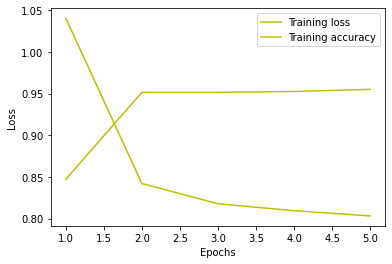

In [56]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
acc = history.history['accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [58]:
# Generate a batch of 3D MRI images
batch_size = 5

img_datagen = imageLoader(train_img_dir, train_img_list,
                          train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = img_datagen.__next__()

print(img.shape)
print(msk.shape)

# Process msks
predicted_msk = model.predict(img)
predicted_msk = np.argmax(predicted_msk, axis=4)
msk = np.argmax(msk, axis=4)

# Show the result
# n_slice = random.randint(0, predicted_msk.shape[3]-1)
n_slice = 55
n_img = random.randint(0, predicted_msk.shape[0]-1)
show_image = img[n_img, :, :, n_slice, :]

(5, 128, 128, 128, 3)
(5, 128, 128, 128, 4)
1/1 [==============================] - 16s 16s/step


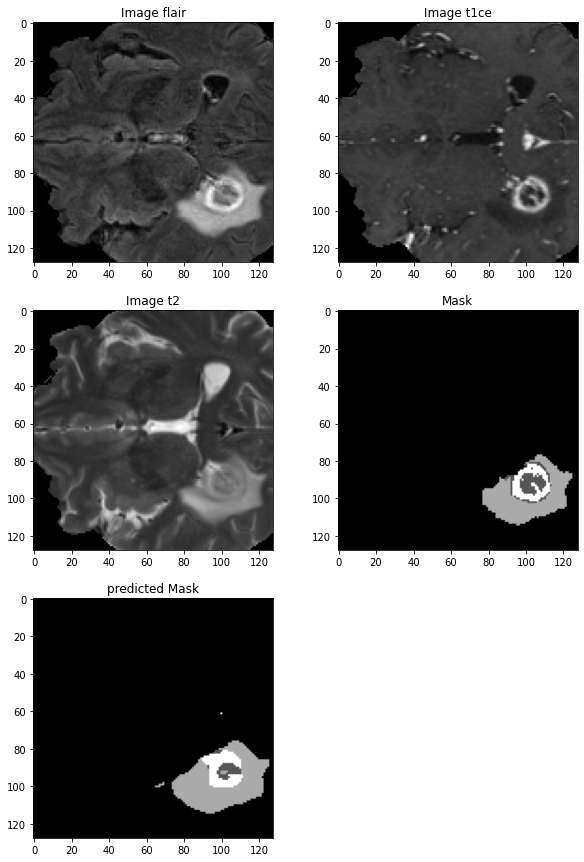

In [59]:
plt.figure(figsize=(10, 15))

plt.subplot(321)
plt.imshow(show_image[:,:,0], cmap='gray')
plt.title('Image flair')
plt.subplot(322)
plt.imshow(show_image[:,:,1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(323)
plt.imshow(show_image[:,:,2], cmap='gray')
plt.title('Image t2')
plt.subplot(324)
plt.imshow(msk[n_img,:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.subplot(325)
plt.imshow(predicted_msk[n_img,:,:,n_slice], cmap='gray')
plt.title('predicted Mask')
plt.show()